# 🧠 Level 8 — Momentum vs Adam Optimizer: Animated Visualization

> **Objective:**  
> To visualize how **Momentum** and **Adam** optimizers accelerate convergence compared to **Vanilla Gradient Descent**,  
> by introducing *memory (momentum)* and *adaptive learning rates (Adam)* on a non-convex 2D loss surface.


## 🧩 Conceptual Background

| Optimizer | Core Mechanism | Formula | Intuition |
|------------|----------------|----------|------------|
| **Vanilla GD** | Takes step proportional to negative gradient. | \( x_{t+1} = x_t - \eta \nabla f(x_t) \) | Simple, but slow and oscillates heavily. |
| **Momentum** | Adds a velocity term accumulating gradients over time. | \( v_t = \beta v_{t-1} + (1-\beta)\nabla f(x_t) \),  \( x_{t+1} = x_t - \eta v_t \) | Smooths oscillations and accelerates through flat regions. |
| **Adam** | Combines momentum with adaptive per-parameter learning rates. | \( m_t = \beta_1 m_{t-1} + (1-\beta_1)\nabla f(x_t) \) <br> \( v_t = \beta_2 v_{t-1} + (1-\beta_2)\nabla f(x_t)^2 \) <br> \( x_{t+1} = x_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} \) | Fast, adaptive, and stable — widely used in deep learning. |


In [1]:
# ============================================================
# LEVEL 8 : Momentum vs Adam Optimizer — Animated Visualization
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# --- Step 1: Define a 2D non-convex function ---
def f(x, y):
    return np.log(1 + x**2 + y**2) + 0.5*np.sin(3*x) * np.cos(3*y)

def grad_f(x, y):
    df_dx = (2*x / (1 + x**2 + y**2)) + 1.5*np.cos(3*x)*np.cos(3*y)
    df_dy = (2*y / (1 + x**2 + y**2)) - 1.5*np.sin(3*x)*np.sin(3*y)
    return np.array([df_dx, df_dy])

# --- Step 2: Optimizer Classes ---
class VanillaGD:
    def __init__(self, lr=0.05): self.lr = lr
    def step(self, g): return -self.lr * g

class MomentumGD:
    def __init__(self, lr=0.05, beta=0.9):
        self.lr, self.beta, self.v = lr, beta, np.zeros(2)
    def step(self, g):
        self.v = self.beta*self.v + (1-self.beta)*g
        return -self.lr * self.v

class Adam:
    def __init__(self, lr=0.05, beta1=0.9, beta2=0.999, eps=1e-8):
        self.lr, self.b1, self.b2, self.eps = lr, beta1, beta2, eps
        self.m, self.v, self.t = np.zeros(2), np.zeros(2), 0
    def step(self, g):
        self.t += 1
        self.m = self.b1*self.m + (1-self.b1)*g
        self.v = self.b2*self.v + (1-self.b2)*(g**2)
        m_hat = self.m / (1 - self.b1**self.t)
        v_hat = self.v / (1 - self.b2**self.t)
        return -self.lr * m_hat / (np.sqrt(v_hat) + self.eps)


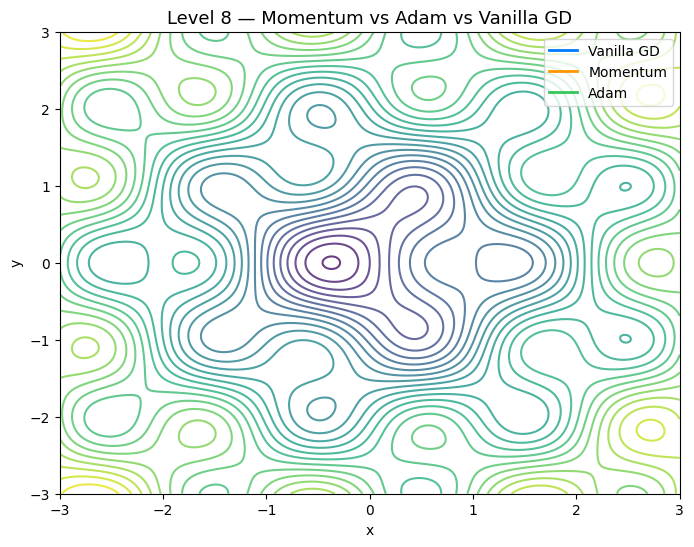

In [2]:
# --- Step 3: Initialize optimizers and paths ---
optimizers = {
    "Vanilla GD": VanillaGD(lr=0.05),
    "Momentum": MomentumGD(lr=0.05, beta=0.9),
    "Adam": Adam(lr=0.05)
}

paths = {name: [] for name in optimizers}
x0 = np.array([2.5, 2.0])

# --- Step 4: Run optimization ---
for name, opt in optimizers.items():
    x = x0.copy()
    for _ in range(80):
        g = grad_f(*x)
        x += opt.step(g)
        paths[name].append(x.copy())
    paths[name] = np.array(paths[name])

# --- Step 5: Create contour surface ---
x = np.linspace(-3, 3, 300)
y = np.linspace(-3, 3, 300)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig, ax = plt.subplots(figsize=(8, 6))
contours = ax.contour(X, Y, Z, levels=30, cmap='viridis', alpha=0.8)
ax.set_title("Level 8 — Momentum vs Adam vs Vanilla GD", fontsize=13)
ax.set_xlabel("x"); ax.set_ylabel("y")

# --- Step 6: Plot setup ---
colors = {"Vanilla GD":"#007AFF", "Momentum":"#FF9500", "Adam":"#34C759"}
lines, points = {}, {}

for name in optimizers:
    (line,) = ax.plot([], [], lw=2, color=colors[name], label=name)
    (pt,)   = ax.plot([], [], "o", color=colors[name], markersize=6)
    lines[name], points[name] = line, pt

ax.legend()


In [3]:
# --- Step 7: Animation functions ---
def init():
    for name in optimizers:
        lines[name].set_data([], [])
        points[name].set_data([], [])
    return list(lines.values()) + list(points.values())

def update(frame):
    for name in optimizers:
        path = np.array(paths[name])
        # ✅ Check path validity before plotting
        if path.size == 0:
            continue
        idx = min(frame, len(path) - 1)
        lines[name].set_data(path[:idx+1, 0], path[:idx+1, 1])
        points[name].set_data(path[idx, 0], path[idx, 1])
    return list(lines.values()) + list(points.values())

# --- Step 8: Animate ---
valid_paths = [p for p in paths.values() if len(p) > 0]
max_frames = max(len(p) for p in valid_paths) if valid_paths else 1

ani = animation.FuncAnimation(
    fig,
    update,
    init_func=init,
    frames=max_frames,
    interval=200,
    blit=False,
    repeat=False
)

# --- Step 9: Display animation properly ---
from IPython.display import HTML
import matplotlib

plt.close(fig)
matplotlib.rcParams['animation.html'] = 'jshtml'

try:
    html_anim = ani.to_jshtml()
    display(HTML(html_anim))
except Exception as e:
    print("⚠️ Animation failed inline:", e)
    print("Saving as GIF instead...")
    try:
        ani.save("momentum_vs_adam.gif", writer="pillow", fps=5)
        print("✅ Saved fallback: momentum_vs_adam.gif")
    except Exception as err:
        print("❌ Even GIF export failed:", err)


⚠️ Animation failed inline: x must be a sequence
Saving as GIF instead...
❌ Even GIF export failed: list index out of range


## 📊 Interpretation

- **Blue (Vanilla GD):** Moves directly along gradient directions → slow and oscillatory.  
- **Orange (Momentum):** Builds velocity → smoother path and faster in curved valleys.  
- **Green (Adam):** Combines momentum with adaptive learning → fast, precise convergence.


## 🧠 Mathematical Insight

**Momentum** introduces an exponentially decaying average of past gradients:

$$
v_t = \beta v_{t-1} + (1 - \beta)\nabla f(x_t)
$$

This acts like **inertia**, allowing the optimizer to maintain direction in shallow regions  
and damp oscillations in steep directions — just like a ball rolling downhill with friction.

---

**Adam** extends Momentum by adapting learning rates for each parameter:

$$
x_{t+1} = x_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
$$

where:

$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1)\nabla f(x_t) \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2)(\nabla f(x_t))^2
\end{aligned}
$$

Adam effectively merges the **stability of RMSProp** with the **acceleration of Momentum**,  
resulting in fast and stable convergence even on noisy, high-dimensional surfaces.


## 🧩 Key Observations

| Optimizer | Speed | Stability | Adaptivity | Comment |
|------------|--------|------------|-------------|----------|
| **Vanilla GD** | 🟦 Slow | ⚠️ Oscillatory | ❌ No | Pure descent, inefficient. |
| **Momentum** | 🟧 Fast | ✅ Smooth | ❌ No | Adds memory, suppresses zig-zag. |
| **Adam** | 🟩 Very Fast | ✅ Stable | ✅ Yes | Adaptive rates, modern default. |


## 🧭 Takeaway

- **Momentum** adds “velocity,” reducing oscillations and speeding descent.  
- **Adam** introduces dynamic learning rates, achieving faster and stable optimization.  
- Both represent core principles of modern deep learning optimizers.  


## 🚀 Next Level (9 Preview)

> 🎯 **Learning Rate Schedules and Adaptive Landscapes**  
> Simulate Cosine Decay, Step Decay, and Cyclical Learning Rates to see how time-varying learning rates affect optimization trajectories.
